In [26]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import time

import matplotlib.pyplot as plt

# Read Data

In [27]:
def readfile(data_dir, label):
    # label是boolean，决定是否传回y值
    image_dir = sorted(os.listdir(data_dir))
    
    # 此处制定好数据类型，后面就不会出错
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(data_dir, file))
        x[i, :, :] = cv2.resize(img, (128, 128))
        if label:
            y[i] = int(file.split("_")[0])
    if label: return x, y
    else: return x

In [28]:
data_dir = 'DATA/hw3/food-11/'
print('reading data...')
train_x, train_y = readfile(os.path.join(data_dir, "training"), True)
val_x, val_y = readfile(os.path.join(data_dir, "validation"), True)
test_x = readfile(os.path.join(data_dir, "testing"), False)

print(len(train_x), len(val_x), len(test_x))

reading data...
9866 3430 3347


(128, 128, 3)


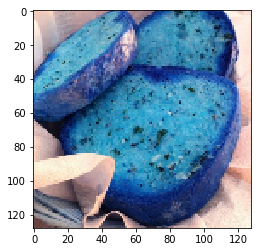

In [51]:
print(train_x[0].shape)
plt.imshow(train_x[0])

此处图片显示为蓝色，是因为cv2读入图片为BGR格式，而plt为RGB格式，正好反了过来。
用索引[2,1,0]可将图片再显示为RGB颜色。但颜色反了并不影响CNN的识别

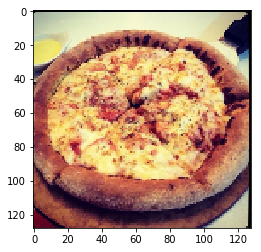

In [52]:
test_plt = train_x[1][:,:,[2,1,0]]
plt.imshow(test_plt)

# Dataset

使用torch.utils.data的Dataset和DataLoader来包装data，方便后续training和testing

In [29]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(), # 将图片转成tensor，并把数值normalize到[0,1]
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            # label is required to be a longTensor
            # 转换成longTensor是因为交叉熵损失函数不能接受one-hot形式
            # 只能接受数组，之后交叉熵函数会自动转换为one-hot
            self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [30]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Model

In [31]:
class Classifier(nn.Module):
    def __init__(self):
        # super继承父类
        super(Classifier, self).__init__()
        # conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # MaxPool2d(kernel_size, stride, padding)
        
        # input维度[3,128,128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), #[64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), #[64, 64, 64]
            
            nn.Conv2d(64, 128, 3, 1, 1),#[128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), #[128, 32, 32]
            
            nn.Conv2d(128, 256, 3, 1, 1),#[256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),#[256, 16, 16]
            
            nn.Conv2d(256, 512, 3, 1, 1),#[512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),#[512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1),#[512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),#[512, 4, 4]
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Linear(512, 11)
        )
    
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Training

training set训练，validation set寻找更好的参数

In [33]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'
model = Classifier().cuda()
# classification task, 所以loss使用crossEntropyLoss
loss = nn.CrossEntropyLoss()
# optimizer使用Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    # 确保model是在train model模式（开启dropout等）
    model.train()
    for i, data in enumerate(train_loader):
        # 用optimizer将model参数的gradient归零，不然会一直累加
        optimizer.zero_grad()
        
        # 利用model得到预测的概率分布，实际上是呼叫model的forward函数
        train_pred = model(data[0].cuda()) # data[0]是x
        batch_loss = loss(train_pred, data[1].cuda()) #data[1]是y
        
        #利用backward算出每个参数的gradient
        batch_loss.backward()
        # 利用optimizer用gradient进行更新参数
        optimizer.step()
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
    # 将模型调为eval模式，固定梯度、bn等操作改变
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())
            
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1)==data[1].numpy())
            val_loss += batch_loss.item()
        
        #将结果print出来
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))          

[001/030] 13.01 sec(s) Train Acc: 0.225927 Loss: 0.020411 | Val Acc: 0.237026 loss: 0.016538
[002/030] 12.76 sec(s) Train Acc: 0.307419 Loss: 0.015554 | Val Acc: 0.322741 loss: 0.014720
[003/030] 12.76 sec(s) Train Acc: 0.357997 Loss: 0.014463 | Val Acc: 0.361516 loss: 0.014342
[004/030] 12.79 sec(s) Train Acc: 0.390533 Loss: 0.013768 | Val Acc: 0.326531 loss: 0.017452
[005/030] 12.79 sec(s) Train Acc: 0.430671 Loss: 0.012845 | Val Acc: 0.404956 loss: 0.014034
[006/030] 12.81 sec(s) Train Acc: 0.456619 Loss: 0.012375 | Val Acc: 0.377551 loss: 0.014393
[007/030] 12.80 sec(s) Train Acc: 0.493817 Loss: 0.011578 | Val Acc: 0.390379 loss: 0.016008
[008/030] 12.83 sec(s) Train Acc: 0.511859 Loss: 0.011229 | Val Acc: 0.484840 loss: 0.011785
[009/030] 12.82 sec(s) Train Acc: 0.525644 Loss: 0.010802 | Val Acc: 0.440816 loss: 0.014105
[010/030] 12.86 sec(s) Train Acc: 0.556963 Loss: 0.010244 | Val Acc: 0.493294 loss: 0.012136
[011/030] 12.94 sec(s) Train Acc: 0.577640 Loss: 0.009707 | Val Acc: 0

得到较好的参数后，使用training和validation共同训练（资料量越多，模型效果越好）

In [34]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [35]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001)
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss =0.0
    
    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/030] 14.70 sec(s) Train Acc: 0.232702 Loss: 0.019616
[002/030] 14.60 sec(s) Train Acc: 0.322353 Loss: 0.014991
[003/030] 14.59 sec(s) Train Acc: 0.383499 Loss: 0.013805
[004/030] 14.64 sec(s) Train Acc: 0.430205 Loss: 0.012842
[005/030] 14.74 sec(s) Train Acc: 0.467434 Loss: 0.011913
[006/030] 14.80 sec(s) Train Acc: 0.511658 Loss: 0.011050
[007/030] 14.82 sec(s) Train Acc: 0.548661 Loss: 0.010263
[008/030] 14.77 sec(s) Train Acc: 0.577091 Loss: 0.009602
[009/030] 14.74 sec(s) Train Acc: 0.596721 Loss: 0.009122
[010/030] 14.75 sec(s) Train Acc: 0.630566 Loss: 0.008408
[011/030] 14.78 sec(s) Train Acc: 0.651098 Loss: 0.008030
[012/030] 14.76 sec(s) Train Acc: 0.664335 Loss: 0.007695
[013/030] 14.76 sec(s) Train Acc: 0.669073 Loss: 0.007524
[014/030] 14.76 sec(s) Train Acc: 0.699759 Loss: 0.006939
[015/030] 14.78 sec(s) Train Acc: 0.713824 Loss: 0.006567
[016/030] 14.78 sec(s) Train Acc: 0.725707 Loss: 0.006262
[017/030] 14.82 sec(s) Train Acc: 0.732852 Loss: 0.006084
[018/030] 14.8

# Testing

利用刚刚train好的model进行prediction

In [36]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [45]:
dataiter = iter(test_loader)
imgs = next(dataiter)
print(imgs.size())

torch.Size([128, 3, 128, 128])


In [47]:
model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        #print(data[0].size())
        # 特别要注意的是，这里直接传入data，因为已经没有y值了，所以无需data[0]。
        # 如果传了data[0]反而导致没有传入整个batch，计算错误
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [48]:
# 将结果写入csv
with open("prediction.csv","w") as f:
    f.write("ID, Category\n")
    for i, y in enumerate(prediction):
        f.write('{},{}\n'.format(i, y))